In [1]:
import numpy as np
import NegotiationTools as negtools
import matplotlib.pyplot as plt
from skimage.draw import rectangle
import skimage as skim
import pandas as pd
import seaborn as sb
import Experiments as exp
import math

stats = negtools.StatisticsLogger()
nt = negtools.NegTools()

No GPU found, model running on CPU


## Templates
A template is the basic form of the ground truth and predictions. It is then converted into a prediction by replicating it for each label/agent. Different objects are labeled with integer numbers, with 0 being the background.

In [2]:
W = 25
H = 25
W2 = 5
H2 = 5
templates = dict()

templates['pixel_spot'] = np.zeros((W, H), dtype=np.uint8)
templates['pixel_spot'][2,2] = 1

templates['single_sq'] = np.zeros((W, H), dtype=np.uint8)
templates['single_sq'][tuple(rectangle(start=(5,5), extent=(15,15), shape=(W,H)))] = 1

templates['multi_sq'] = np.zeros((W, H), dtype=np.uint8)
templates['multi_sq'][1,1] = 1
templates['multi_sq'][1,3] = 2
templates['multi_sq'][3,1] = 3
templates['multi_sq'][3,3] = 4

templates['bin_blob'] = np.zeros((W, H), dtype=np.uint8)
templates['bin_blob'][tuple(rectangle(start=(5,5), extent=(15,15), shape=(W,H)))] = 1

templates['bin_chk'] = np.zeros((W, H), dtype=np.uint8)
is_one = True
for i in range(0,W,W2):
    for j in range(0,H,H2):
        if is_one is True:
            templates['bin_chk'][tuple(rectangle(start=(i,j), extent=(W2,H2), shape=(W,H)))] = 1
        is_one = not is_one
        
n_class = 4
blobs_w = 8
blobs_h = 8
w_off = 2
h_off = 2
blobs_val = 1

templates['blobs'] = np.zeros((W, H), dtype=np.uint8)
for i in range(0,W,blobs_w+2*w_off):
    for j in range(0,H,blobs_h+2*h_off):
        templates['blobs'][tuple(rectangle(start=(i+w_off,j+h_off), extent=(blobs_w,blobs_h), shape=(W,H)))] = blobs_val
        blobs_val = blobs_val+1

W = 25
H = 25
CHK_W = 5
CHK_H = 5
val = 0
n_class = 4
templates['chk'] = np.zeros((W, H), dtype=np.uint8)
is_one = True
for i in range(0,W,CHK_W):
    for j in range(0,H,CHK_H):
        templates['chk'][tuple(rectangle(start=(i,j), extent=(CHK_W,CHK_H), shape=(W,H)))] = val + 1
        val = (val + 1) % n_class

templates['checkerboard'] = skim.data.checkerboard().astype(np.bool).astype(np.float32)


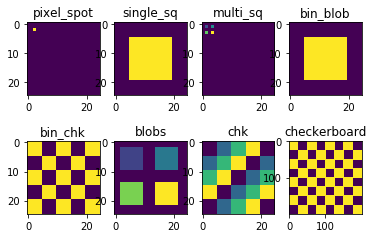

In [3]:
for i, (name, templ) in enumerate(templates.items()):
    plt.subplot(2, math.ceil(len(templates.items())/2), i+1)
    plt.imshow(templ)
    plt.title(name)

In [4]:
def agent_binary_balanced(mu, std):

    mu_mat = [[mu, 1.-mu],
           [1.-mu, mu]]
    std_mat = np.ones_like(mu_mat)*std
    return (np.asarray(mu_mat),np.asarray(std_mat))

def agent_binary_unbalanced(mu_1, mu_2, std):
    
    mu_mat = [[mu_1, 1.-mu_1],
           [1.-mu_2, mu_2]]
    std_mat = np.ones_like(mu_mat)*std
    return (np.asarray(mu_mat),np.asarray(std_mat))


def agent_expert(mu_star, mu, std, c_star, n_labels):
    '''
    :param mu_star - "competence" on expertise class
    :param mu - "competence" on non expertise classes
    :param std - standard deviation
    :param c_star - index of expertise class
    :param n_labels - number of labels
    '''
    samp_mu = np.random.normal(loc=mu, scale=std)
    samp_mu_star = np.random.normal(loc=mu_star, scale=std)
    samp_c_star_others = (1. - samp_mu_star)/(n_labels - 1.)
    samp_gamma = (1. - samp_c_star_others - samp_mu) / (n_labels-2.) if n_labels > 2 else 0

    mat = list()
    for t in range(n_labels):
        row = list()
        for p in range(n_labels):
            if p == c_star and t == c_star:
                row.append(samp_mu_star)
            elif t == c_star or p == c_star:
                row.append(samp_c_star_others)
            elif p == t:
                row.append(samp_mu)
            else:
                row.append(samp_gamma)
        mat.append(row)
    return np.asarray(mat)

def generate_predictions(gt_template, mu_matrix, std_matrix):
    prediction = list()
    # Iterating through the columns (predicted classes) of agent matrix, filling the corresponding ground_truth areas with predictions
    for pred_label in range(mu_matrix.shape[-1]):
        label_image = np.zeros_like(gt_template)
        for true_label in np.unique(gt_template):
            agent_labels = np.random.normal(loc=np.ones_like(gt_template)*mu_matrix[true_label, pred_label],scale=np.ones_like(gt_template)*std_matrix[true_label,pred_label])
            label_image = np.where(gt_template == true_label, agent_labels, label_image)
        prediction.append(label_image)
    return np.stack(prediction, axis=-1)

def generate_ground_truth(gt_template, n_labels):
    gt = list()
    for l in range(n_labels):
        gt_slice = np.where(gt_template==l, 1.0, 0.0)
        gt.append(gt_slice)
    return np.stack(gt, axis=-1)

## Balanced (Binary)

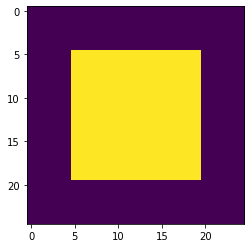

In [5]:
plt.imshow(templates['bin_blob'])

In [6]:
N_LABELS = 2
N_AGENTS = 3

mu = 0.75
std = 0.2
c_star = 0
template = templates['bin_blob']

# Generating agents
agents = [agent_binary_balanced(mu=mu, std=std) for a in range(N_AGENTS)]
# Generating ground truth and predictions
gt = generate_ground_truth(template, N_LABELS)
predictions = np.stack([generate_predictions(template, mu_matrix, std_matrix) for (mu_matrix, std_matrix) in agents])

In [12]:
print(predictions[1][1])

[[ 0.78837195  0.27434022]
 [ 0.74384555  0.4683648 ]
 [ 0.77933936  0.68256513]
 [ 0.76471527  0.60839019]
 [ 0.64947891  0.21953834]
 [ 0.66230684  0.20010019]
 [ 0.59499945  0.21701312]
 [ 0.59471751  0.01937424]
 [ 0.71361049  0.25704437]
 [ 0.84888766  0.47146338]
 [ 0.91396686  0.03437546]
 [ 0.58118789  0.18187182]
 [ 0.77217668 -0.07086864]
 [ 0.9691393   0.2623055 ]
 [ 0.72091104  0.42940739]
 [ 0.92748697 -0.05701521]
 [ 0.34881157  0.20567119]
 [ 0.57380517  0.30034893]
 [ 0.72225054  0.16785516]
 [ 0.85180059  0.32040097]
 [ 0.6107936   0.03099966]
 [ 0.60963919  0.50717916]
 [ 0.65404201  0.02641276]
 [ 0.82240049  0.34786286]
 [ 0.78666316  0.28203008]]


In [9]:
exp.run_experiment_on_list([predictions], [gt])

Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps


,Label 0_f1-score,Label 0_precision,Label 0_recall,Label 0_support,Label 1_f1-score,Label 1_precision,Label 1_recall,Label 1_support,accuracy,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,method
0,0.957447,0.957447,0.957447,47.0,0.916667,0.916667,0.916667,24.0,0.943662,0.937057,0.937057,0.937057,71.0,0.943662,0.943662,0.943662,71.0,Majority Voting
1,0.933333,0.976744,0.893617,47.0,0.884615,0.821429,0.958333,24.0,0.915493,0.908974,0.899086,0.925975,71.0,0.916865,0.924243,0.915493,71.0,Maximum Proposal
2,0.989247,1.000000,0.978723,47.0,0.979592,0.960000,1.000000,24.0,0.985915,0.984420,0.980000,0.989362,71.0,0.985983,0.986479,0.985915,71.0,Mean Proposal
3,0.796610,0.661972,1.000000,47.0,0.000000,0.000000,0.000000,24.0,0.661972,0.398305,0.330986,0.500000,71.0,0.527333,0.438207,0.661972,71.0,Negotiation - 3x3 Conv Entropy
4,0.796610,0.661972,1.000000,47.0,0.000000,0.000000,0.000000,24.0,0.661972,0.398305,0.330986,0.500000,71.0,0.527333,0.438207,0.661972,71.0,Negotiation - 5x5 Conv Entropy
5,0.796610,0.661972,1.000000,47.0,0.000000,0.000000,0.000000,24.0,0.661972,0.398305,0.330986,0.500000,71.0,0.527333,0.438207,0.661972,71.0,Negotiation - Mean Entropy
6,0.958333,0.938776,0.978723,47.0,0.913043,0.954545,0.875000,24.0,0.943662,0.935688,0.946660,0.926862,71.0,0.943024,0.944106,0.943662,71.0,Negotiation - Pixelwise Entropy
7,0.796610,0.661972,1.000000,47.0,0.000000,0.000000,0.000000,24.0,0.661972,0.398305,0.330986,0.500000,71.0,0.527333,0.438207,0.661972,71.0,Weighted Mean - 3x3 Conv Entropy
8,0.796610,0.661972,1.000000,47.0,0.000000,0.000000,0.000000,24.0,0.661972,0.398305,0.330986,0.500000,71.0,0.527333,0.438207,0.661972,71.0,Weighted Mean - 5x5 Conv Entropy
9,0.796610,0.661972,1.000000,47.0,0.000000,0.000000,0.000000,24.0,0.661972,0.398305,0.330986,0.500000,71.0,0.527333,0.438207,0.661972,71.0,Weighted Mean - Mean Entropy


## Unbalanced on C1 (Binary)

In [155]:
N_LABELS = 2
N_AGENTS = 3

mu_1 = 0.6
mu_2 = 0.4
std = 0.01
c_star = 0
template = templates['blob']

# Generating agents
agents = [agent_binary_unbalanced(mu_1=mu_1, mu_2=mu_2, std=std) for a in range(N_AGENTS)]
# Generating ground truth and predictions
gt = generate_ground_truth(template, N_LABELS)
predictions = np.stack([generate_predictions(template, agent_matrix) for agent_matrix in agents])

In [156]:
exp.run_experiment_on_list([predictions], [gt])

Sample 0 Consensus Reached at step, current step: 0
Sample 0 Consensus Reached at step, current step: 0
Sample 0 Consensus Reached at step, current step: 0
Sample 0 Consensus Reached at step, current step: 0


,Label 0_f1-score,Label 0_precision,Label 0_recall,Label 0_support,Label 1_f1-score,Label 1_precision,Label 1_recall,Label 1_support,accuracy,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,method
0,0.780488,0.64,1.0,400.0,0.0,0.0,0.0,225.0,0.64,0.390244,0.32,0.5,625.0,0.499512,0.4096,0.64,625.0,Majority Voting
1,0.780488,0.64,1.0,400.0,0.0,0.0,0.0,225.0,0.64,0.390244,0.32,0.5,625.0,0.499512,0.4096,0.64,625.0,Maximum Proposal
2,0.780488,0.64,1.0,400.0,0.0,0.0,0.0,225.0,0.64,0.390244,0.32,0.5,625.0,0.499512,0.4096,0.64,625.0,Mean Proposal
3,0.780488,0.64,1.0,400.0,0.0,0.0,0.0,225.0,0.64,0.390244,0.32,0.5,625.0,0.499512,0.4096,0.64,625.0,Negotiation - 3x3 Conv Entropy
4,0.780488,0.64,1.0,400.0,0.0,0.0,0.0,225.0,0.64,0.390244,0.32,0.5,625.0,0.499512,0.4096,0.64,625.0,Negotiation - 5x5 Conv Entropy
5,0.780488,0.64,1.0,400.0,0.0,0.0,0.0,225.0,0.64,0.390244,0.32,0.5,625.0,0.499512,0.4096,0.64,625.0,Negotiation - Mean Entropy
6,0.780488,0.64,1.0,400.0,0.0,0.0,0.0,225.0,0.64,0.390244,0.32,0.5,625.0,0.499512,0.4096,0.64,625.0,Negotiation - Pixelwise Entropy
7,0.780488,0.64,1.0,400.0,0.0,0.0,0.0,225.0,0.64,0.390244,0.32,0.5,625.0,0.499512,0.4096,0.64,625.0,Weighted Mean - 3x3 Conv Entropy
8,0.780488,0.64,1.0,400.0,0.0,0.0,0.0,225.0,0.64,0.390244,0.32,0.5,625.0,0.499512,0.4096,0.64,625.0,Weighted Mean - 5x5 Conv Entropy
9,0.780488,0.64,1.0,400.0,0.0,0.0,0.0,225.0,0.64,0.390244,0.32,0.5,625.0,0.499512,0.4096,0.64,625.0,Weighted Mean - Mean Entropy


## Unbalanced on C2 (Binary)

In [158]:
N_LABELS = 2
N_AGENTS = 3

mu_1 = 0.4
mu_2 = 0.6
std = 0.01
c_star = 0
template = templates['blob']

# Generating agents
agents = [agent_binary_unbalanced(mu_1=mu_1, mu_2=mu_2, std=std) for a in range(N_AGENTS)]
# Generating ground truth and predictions
gt = generate_ground_truth(template, N_LABELS)
predictions = np.stack([generate_predictions(template, agent_matrix) for agent_matrix in agents])

In [159]:
exp.run_experiment_on_list([predictions], [gt])

Sample 0 Consensus Reached at step, current step: 0
Sample 0 Consensus Reached at step, current step: 0
Sample 0 Consensus Reached at step, current step: 0
Sample 0 Consensus Reached at step, current step: 0


,Label 0_f1-score,Label 0_precision,Label 0_recall,Label 0_support,Label 1_f1-score,Label 1_precision,Label 1_recall,Label 1_support,accuracy,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,method
0,0.0,0.0,0.0,400.0,0.529412,0.36,1.0,225.0,0.36,0.264706,0.18,0.5,625.0,0.190588,0.1296,0.36,625.0,Majority Voting
1,0.0,0.0,0.0,400.0,0.529412,0.36,1.0,225.0,0.36,0.264706,0.18,0.5,625.0,0.190588,0.1296,0.36,625.0,Maximum Proposal
2,0.0,0.0,0.0,400.0,0.529412,0.36,1.0,225.0,0.36,0.264706,0.18,0.5,625.0,0.190588,0.1296,0.36,625.0,Mean Proposal
3,0.0,0.0,0.0,400.0,0.529412,0.36,1.0,225.0,0.36,0.264706,0.18,0.5,625.0,0.190588,0.1296,0.36,625.0,Negotiation - 3x3 Conv Entropy
4,0.0,0.0,0.0,400.0,0.529412,0.36,1.0,225.0,0.36,0.264706,0.18,0.5,625.0,0.190588,0.1296,0.36,625.0,Negotiation - 5x5 Conv Entropy
5,0.0,0.0,0.0,400.0,0.529412,0.36,1.0,225.0,0.36,0.264706,0.18,0.5,625.0,0.190588,0.1296,0.36,625.0,Negotiation - Mean Entropy
6,0.0,0.0,0.0,400.0,0.529412,0.36,1.0,225.0,0.36,0.264706,0.18,0.5,625.0,0.190588,0.1296,0.36,625.0,Negotiation - Pixelwise Entropy
7,0.0,0.0,0.0,400.0,0.529412,0.36,1.0,225.0,0.36,0.264706,0.18,0.5,625.0,0.190588,0.1296,0.36,625.0,Weighted Mean - 3x3 Conv Entropy
8,0.0,0.0,0.0,400.0,0.529412,0.36,1.0,225.0,0.36,0.264706,0.18,0.5,625.0,0.190588,0.1296,0.36,625.0,Weighted Mean - 5x5 Conv Entropy
9,0.0,0.0,0.0,400.0,0.529412,0.36,1.0,225.0,0.36,0.264706,0.18,0.5,625.0,0.190588,0.1296,0.36,625.0,Weighted Mean - Mean Entropy


## Expert C* (Multiclass)

In [117]:
N_LABELS = 5
N_AGENTS = 3

mu_star = 1.5/N_LABELS
mu = 1/N_LABELS
std = 0.01
c_star = 0
template = templates['blobs']

# Generating agents
agents = [agent_expert(mu_star=mu_star, mu=mu, std=std, c_star=c_star, n_labels=N_LABELS) for a in range(N_AGENTS)]
# Generating ground truth and predictions
gt = generate_ground_truth(template, N_LABELS)
predictions = np.stack([generate_predictions(template, agent_matrix) for agent_matrix in agents])


In [119]:
predictions.shape

(3, 25, 25, 5)

In [120]:
exp.run_experiment_on_list([predictions], [gt])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Sample 0 Consensus Reached at step, current step: 0
Sample 0 Consensus Reached at step, current step: 0
Sample 0 Consensus Reached at step, current step: 0
Sample 0 Consensus Reached at step, current step: 0


,Label 0_f1-score,Label 0_precision,Label 0_recall,Label 0_support,Label 1_f1-score,Label 1_precision,Label 1_recall,Label 1_support,Label 2_f1-score,Label 2_precision,...,accuracy,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,method
0,1.0,1.0,1.0,205.0,0.0,0.0,0.0,100.0,0.0,0.0,...,0.328,0.2,0.2,0.2,625.0,0.328,0.328,0.328,625.0,Majority Voting
1,1.0,1.0,1.0,205.0,0.0,0.0,0.0,100.0,0.0,0.0,...,0.328,0.2,0.2,0.2,625.0,0.328,0.328,0.328,625.0,Maximum Proposal
2,1.0,1.0,1.0,205.0,0.0,0.0,0.0,100.0,0.0,0.0,...,0.328,0.2,0.2,0.2,625.0,0.328,0.328,0.328,625.0,Mean Proposal
3,1.0,1.0,1.0,205.0,0.0,0.0,0.0,100.0,0.0,0.0,...,0.328,0.2,0.2,0.2,625.0,0.328,0.328,0.328,625.0,Negotiation - 3x3 Conv Entropy
4,1.0,1.0,1.0,205.0,0.0,0.0,0.0,100.0,0.0,0.0,...,0.328,0.2,0.2,0.2,625.0,0.328,0.328,0.328,625.0,Negotiation - 5x5 Conv Entropy
5,1.0,1.0,1.0,205.0,0.0,0.0,0.0,100.0,0.0,0.0,...,0.328,0.2,0.2,0.2,625.0,0.328,0.328,0.328,625.0,Negotiation - Mean Entropy
6,1.0,1.0,1.0,205.0,0.0,0.0,0.0,100.0,0.0,0.0,...,0.328,0.2,0.2,0.2,625.0,0.328,0.328,0.328,625.0,Negotiation - Pixelwise Entropy
7,1.0,1.0,1.0,205.0,0.0,0.0,0.0,100.0,0.0,0.0,...,0.328,0.2,0.2,0.2,625.0,0.328,0.328,0.328,625.0,Weighted Mean - 3x3 Conv Entropy
8,1.0,1.0,1.0,205.0,0.0,0.0,0.0,100.0,0.0,0.0,...,0.328,0.2,0.2,0.2,625.0,0.328,0.328,0.328,625.0,Weighted Mean - 5x5 Conv Entropy
9,1.0,1.0,1.0,205.0,0.0,0.0,0.0,100.0,0.0,0.0,...,0.328,0.2,0.2,0.2,625.0,0.328,0.328,0.328,625.0,Weighted Mean - Mean Entropy


In [160]:
# TODO: Add unbalanced multiclass

## Experimental Design (Binary)

#### 1 balanced agent vs 2, 4, 8 unbalanced on C1

In [ ]:
c_star = 0
template = templates['blob']
N_LABELS = 2
gt = generate_ground_truth(template, N_LABELS)
SAMPLES = 30
log = pd.DataFrame()
for unb_agents in [2, 4, 8]:
    for std in [0.01,0.05,0.1,0.2]:
        for mu_balanced in [.6, .75, .9]:
            # Balanced Agent
            balanced = agent_binary_balanced(mu=mu, std=std)

            for mu_1_unbalanced in [.6, .75, .9]:
                for mu_2_unbalanced in [0.4, 0.5]:
                    # Running "SAMPLES" times
                    prediction_runs = list()

                    for i in range(SAMPLES):
                        agents = [balanced] + [agent_binary_unbalanced(mu_1=mu_1_unbalanced, mu_2=mu_2_unbalanced, std=std) for a in range(unb_agents)]        
                        predictions = np.stack([generate_predictions(template, agent_matrix) for agent_matrix in agents])
                        prediction_runs.append(predictions)

                    results = exp.run_experiment_on_list(prediction_runs, [gt]*SAMPLES)
                    results['unbalanced_agents'] = unb_agents
                    results['mu_balanced'] = mu_balanced
                    results['mu_1_unbalanced'] = mu_1_unbalanced
                    results['mu_2_unbalanced'] = mu_2_unbalanced
                    results['std'] = std
                    log = log.append(results, ignore_index=True)
log.to_csv('results/binary_balanced_vs_unbalanced_c1_std_{}'.format(std))